# 0) Setup & imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import TransformedTargetRegressor

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Setting to make numbers easier to read on display
pd.options.display.float_format = '{:20.2f}'.format

# Show all columns on output
pd.set_option('display.max_columns', 999)

RANDOM_STATE = 42

# 1) Basic info on the data

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
print('Loaded train:', train_df.shape, 'test:', test_df.shape)

Loaded train: (1460, 81) test: (1459, 80)


In [3]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.00,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.00,TA,TA,CBlock,TA,TA,No,Rec,468.00,LwQ,144.00,270.00,882.00,GasA,TA,Y,SBrkr,896,0,0,896,0.00,0.00,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.00,Unf,1.00,730.00,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.00,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.00,TA,TA,CBlock,TA,TA,No,ALQ,923.00,Unf,0.00,406.00,1329.00,GasA,TA,Y,SBrkr,1329,0,0,1329,0.00,0.00,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.00,Unf,1.00,312.00,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.00,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.00,TA,TA,PConc,Gd,TA,No,GLQ,791.00,Unf,0.00,137.00,928.00,GasA,Gd,Y,SBrkr,928,701,0,1629,0.00,0.00,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.00,Fin,2.00,482.00,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.00,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.00,TA,TA,PConc,TA,TA,No,GLQ,602.00,Unf,0.00,324.00,926.00,GasA,Ex,Y,SBrkr,926,678,0,1604,0.00,0.00,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.00,Fin,2.00,470.00,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.00,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,NaN,0.00,Gd,TA,PConc,Gd,TA,No,ALQ,263.00,Unf,0.00,1017.00,1280.00,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.00,0.00,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.00,RFn,2.00,506.00,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [4]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.00,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.00,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.00,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.00,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.00,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.00,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
# catgorical
train_df.describe(include='O')

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,588,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,3,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,445,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


In [7]:
# numerical
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.00,1460.00,1201.00,1460.00,1460.00,1460.00,1460.00,1460.00,1452.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1379.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00
mean,730.50,56.90,70.05,10516.83,6.10,5.58,1971.27,1984.87,103.69,443.64,46.55,567.24,1057.43,1162.63,346.99,5.84,1515.46,0.43,0.06,1.57,0.38,2.87,1.05,6.52,0.61,1978.51,1.77,472.98,94.24,46.66,21.95,3.41,15.06,2.76,43.49,6.32,2007.82,180921.20
std,421.61,42.30,24.28,9981.26,1.38,1.11,30.20,20.65,181.07,456.10,161.32,441.87,438.71,386.59,436.53,48.62,525.48,0.52,0.24,0.55,0.50,0.82,0.22,1.63,0.64,24.69,0.75,213.80,125.34,66.26,61.12,29.32,55.76,40.18,496.12,2.70,1.33,79442.50
min,1.00,20.00,21.00,1300.00,1.00,1.00,1872.00,1950.00,0.00,0.00,0.00,0.00,0.00,334.00,0.00,0.00,334.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,1900.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2006.00,34900.00
25%,365.75,20.00,59.00,7553.50,5.00,5.00,1954.00,1967.00,0.00,0.00,0.00,223.00,795.75,882.00,0.00,0.00,1129.50,0.00,0.00,1.00,0.00,2.00,1.00,5.00,0.00,1961.00,1.00,334.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,2007.00,129975.00
50%,730.50,50.00,69.00,9478.50,6.00,5.00,1973.00,1994.00,0.00,383.50,0.00,477.50,991.50,1087.00,0.00,0.00,1464.00,0.00,0.00,2.00,0.00,3.00,1.00,6.00,1.00,1980.00,2.00,480.00,0.00,25.00,0.00,0.00,0.00,0.00,0.00,6.00,2008.00,163000.00
75%,1095.25,70.00,80.00,11601.50,7.00,6.00,2000.00,2004.00,166.00,712.25,0.00,808.00,1298.25,1391.25,728.00,0.00,1776.75,1.00,0.00,2.00,1.00,3.00,1.00,7.00,1.00,2002.00,2.00,576.00,168.00,68.00,0.00,0.00,0.00,0.00,0.00,8.00,2009.00,214000.00
max,1460.00,190.00,313.00,215245.00,10.00,9.00,2010.00,2010.00,1600.00,5644.00,1474.00,2336.00,6110.00,4692.00,2065.00,572.00,5642.00,3.00,2.00,3.00,2.00,8.00,3.00,14.00,3.00,2010.00,4.00,1418.00,857.00,547.00,552.00,508.00,480.00,738.00,15500.00,12.00,2010.00,755000.00


# 2) EDA, feature engineering, handling outliers and NaN values

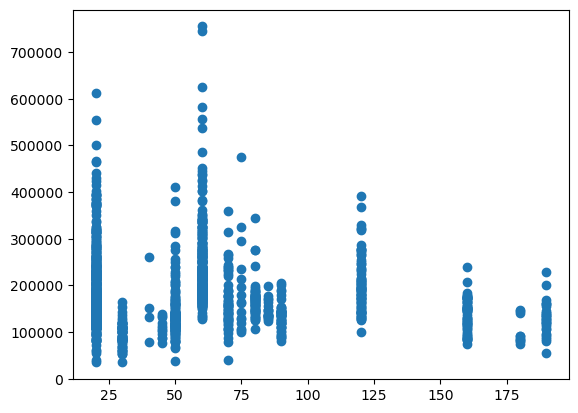

In [9]:
# EDA - outliers
# scatter plots on numerical columns

plt.scatter(x='MSSubClass', y='SalePrice', data=train_df)

In [8]:
train_df.dtypes[train_df.dtypes != 'object']

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object

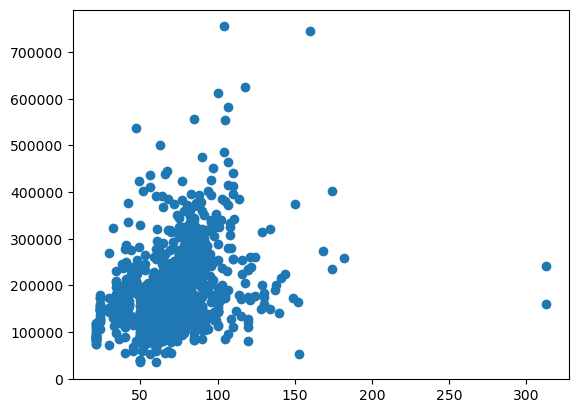

In [10]:
plt.scatter(x='LotFrontage', y='SalePrice', data=train_df)

In [11]:
# querying for outliers
# DROP ID 934, 1298
train_df.query('LotFrontage > 300')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
934,935,20,RL,313.00,27650,Pave,NaN,IR2,HLS,AllPub,Inside,Mod,NAmes,PosA,Norm,1Fam,1Story,7,7,1960,2007,Flat,Tar&Grv,Wd Sdng,Wd Sdng,NaN,0.00,TA,TA,CBlock,Gd,TA,Gd,GLQ,425,Unf,0,160,585,GasA,Ex,Y,SBrkr,2069,0,0,2069,1,0,2,0,4,1,Gd,9,Typ,1,Gd,Attchd,1960.00,RFn,2,505,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,11,2008,WD,Normal,242000
1298,1299,60,RL,313.00,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.00,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.00,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


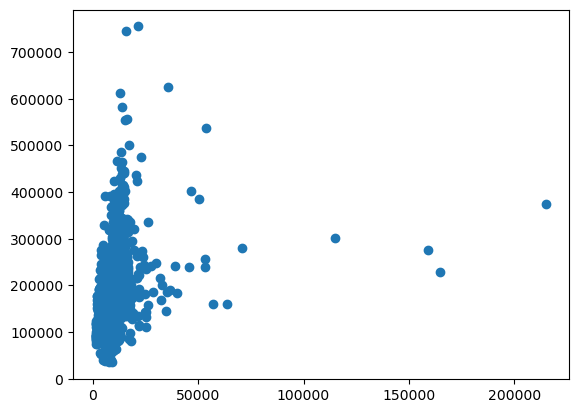

In [12]:
# some very pricy houses
plt.scatter(x='LotArea', y='SalePrice', data=train_df)

In [13]:
# DROP 250, 314, 336, 707
# maybe 1397
train_df.query('LotArea > 55000')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
249,250,50,RL,NaN,159000,Pave,NaN,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1.5Fin,6,7,1958,2006,Gable,CompShg,Wd Sdng,HdBoard,BrkCmn,472.00,Gd,TA,CBlock,Gd,TA,Gd,Rec,697,Unf,0,747,1444,GasA,Gd,Y,SBrkr,1444,700,0,2144,0,1,2,0,4,1,Gd,7,Typ,2,TA,Attchd,1958.00,Fin,2,389,TA,TA,Y,0,98,0,0,0,0,NaN,NaN,Shed,500,6,2007,WD,Normal,277000
313,314,20,RL,150.00,215245,Pave,NaN,IR3,Low,AllPub,Inside,Sev,Timber,Norm,Norm,1Fam,1Story,7,5,1965,1965,Hip,CompShg,BrkFace,BrkFace,NaN,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,1236,Rec,820,80,2136,GasW,TA,Y,SBrkr,2036,0,0,2036,2,0,2,0,3,1,TA,8,Typ,2,Gd,Attchd,1965.00,RFn,2,513,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal,375000
335,336,190,RL,NaN,164660,Grvl,NaN,IR1,HLS,AllPub,Corner,Sev,Timber,Norm,Norm,2fmCon,1.5Fin,5,6,1965,1965,Gable,CompShg,Plywood,Plywood,NaN,0.00,TA,TA,CBlock,TA,TA,Gd,ALQ,1249,BLQ,147,103,1499,GasA,Ex,Y,SBrkr,1619,167,0,1786,2,0,2,0,3,1,TA,7,Typ,2,Gd,Attchd,1965.00,Fin,2,529,TA,TA,Y,670,0,0,0,0,0,NaN,NaN,Shed,700,8,2008,WD,Normal,228950
451,452,20,RL,62.00,70761,Pave,NaN,IR1,Low,AllPub,Inside,Mod,ClearCr,Norm,Norm,1Fam,1Story,7,5,1975,1975,Gable,WdShngl,Plywood,Plywood,NaN,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,655,Unf,0,878,1533,GasA,TA,Y,SBrkr,1533,0,0,1533,1,0,2,0,2,1,Gd,5,Typ,2,TA,Attchd,1975.00,Unf,2,576,TA,TA,Y,200,54,0,0,0,0,NaN,NaN,NaN,0,12,2006,WD,Normal,280000
706,707,20,RL,NaN,115149,Pave,NaN,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1Story,7,5,1971,2002,Gable,CompShg,Plywood,Plywood,Stone,351.00,TA,TA,CBlock,Gd,TA,Gd,GLQ,1219,Unf,0,424,1643,GasA,TA,Y,SBrkr,1824,0,0,1824,1,0,2,0,2,1,Gd,5,Typ,2,TA,Attchd,1971.00,Unf,2,739,TA,TA,Y,380,48,0,0,0,0,NaN,NaN,NaN,0,6,2007,WD,Normal,302000
1298,1299,60,RL,313.00,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.00,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.00,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
1396,1397,20,RL,NaN,57200,Pave,NaN,IR1,Bnk,AllPub,Inside,Sev,Timber,Norm,Norm,1Fam,1Story,5,5,1948,1950,Gable,CompShg,Wd Sdng,Wd Sdng,NaN,0.00,TA,TA,CBlock,TA,TA,Av,BLQ,353,Rec,334,60,747,GasA,TA,Y,SBrkr,1687,0,0,1687,1,0,1,0,3,1,TA,7,Min1,2,TA,Detchd,1966.00,Unf,2,572,TA,TA,N,0,0,50,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,160000


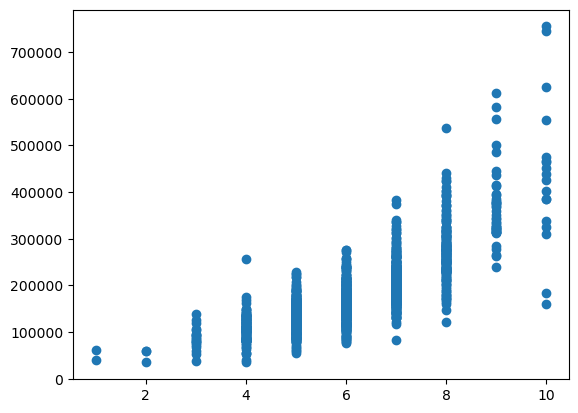

In [14]:
plt.scatter(x='OverallQual', y='SalePrice', data=train_df)

In [15]:
train_df.query('OverallQual == 10')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
58,59,60,RL,66.00,13682,Pave,NaN,IR2,HLS,AllPub,CulDSac,Gtl,StoneBr,Norm,Norm,1Fam,2Story,10,5,2006,2006,Hip,CompShg,VinylSd,VinylSd,BrkFace,1031.00,Ex,TA,PConc,Ex,TA,Gd,Unf,0,Unf,0,1410,1410,GasA,Ex,Y,SBrkr,1426,1519,0,2945,0,0,3,1,3,1,Gd,10,Typ,1,Gd,BuiltIn,2006.00,Fin,3,641,TA,TA,Y,192,0,37,0,0,0,NaN,NaN,NaN,0,10,2006,New,Partial,438780
185,186,75,RM,90.00,22950,Pave,NaN,IR2,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,2.5Fin,10,9,1892,1993,Gable,WdShngl,Wd Sdng,Wd Sdng,NaN,0.00,Gd,Gd,BrkTil,TA,TA,Mn,Unf,0,Unf,0,1107,1107,GasA,Ex,Y,SBrkr,1518,1518,572,3608,0,0,2,1,4,1,Ex,12,Typ,2,TA,Detchd,1993.00,Unf,3,840,Ex,TA,Y,0,260,0,0,410,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000
224,225,20,RL,103.00,13472,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2003,2003,Hip,CompShg,VinylSd,VinylSd,BrkFace,922.00,Ex,TA,PConc,Ex,TA,Gd,GLQ,56,Unf,0,2336,2392,GasA,Ex,Y,SBrkr,2392,0,0,2392,0,0,2,0,3,1,Ex,8,Typ,1,Ex,Attchd,2003.00,Fin,3,968,TA,TA,Y,248,105,0,0,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal,386250
389,390,60,RL,96.00,12474,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,2Story,10,5,2007,2008,Gable,CompShg,VinylSd,VinylSd,Stone,272.00,Ex,TA,PConc,Ex,TA,Av,GLQ,1280,Unf,0,402,1682,GasA,Ex,Y,SBrkr,1742,590,0,2332,1,0,2,1,3,1,Ex,9,Typ,1,Ex,BuiltIn,2008.00,Fin,3,846,TA,TA,Y,196,134,0,0,0,0,NaN,NaN,NaN,0,8,2008,New,Partial,426000
440,441,20,RL,105.00,15431,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2008,2008,Hip,CompShg,VinylSd,VinylSd,Stone,200.00,Ex,TA,PConc,Ex,TA,Gd,GLQ,1767,ALQ,539,788,3094,GasA,Ex,Y,SBrkr,2402,0,0,2402,1,0,2,0,2,1,Ex,10,Typ,2,Gd,Attchd,2008.00,Fin,3,672,TA,TA,Y,0,72,0,0,170,0,NaN,NaN,NaN,0,4,2009,WD,Normal,555000
515,516,20,RL,94.00,12220,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2009,2009,Hip,CompShg,CemntBd,CmentBd,BrkFace,305.00,Ex,TA,CBlock,Ex,TA,No,GLQ,1436,Unf,0,570,2006,GasA,Ex,Y,SBrkr,2020,0,0,2020,1,0,2,1,3,1,Ex,9,Typ,1,Gd,Attchd,2009.00,Fin,3,900,TA,TA,Y,156,54,0,0,0,0,NaN,NaN,NaN,0,9,2009,New,Partial,402861
523,524,60,RL,130.00,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.00,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.00,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
583,584,75,RM,75.00,13500,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,PosA,1Fam,2.5Unf,10,9,1893,2000,Gable,CompShg,Wd Sdng,Wd Sdng,NaN,0.00,Ex,Ex,BrkTil,TA,TA,No,Unf,0,Unf,0,1237,1237,GasA,Gd,Y,SBrkr,1521,1254,0,2775,0,0,3,1,3,1,Gd,9,Typ,1,Gd,Detchd,1988.00,Unf,2,880,Gd,TA,Y,105,502,0,0,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal,325000
591,592,60,RL,97.00,13478,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NridgHt,Norm,Norm,1Fam,2Story,10,5,2008,2008,Gable,CompShg,CemntBd,CmentBd,Stone,420.00,Ex,TA,PConc,Ex,TA,Gd,GLQ,1338,Unf,0,384,1722,GasA,Ex,Y,SBrkr,1728,568,0,2296,1,0,2,1,3,1,Ex,10,Typ,1,Gd,BuiltIn,2008.00,RFn,3,842,TA,TA,Y,382,274,0,0,0,0,NaN,NaN,NaN,0,6,2009,ConLI,Normal,451950
691,692,60,RL,104.00,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm

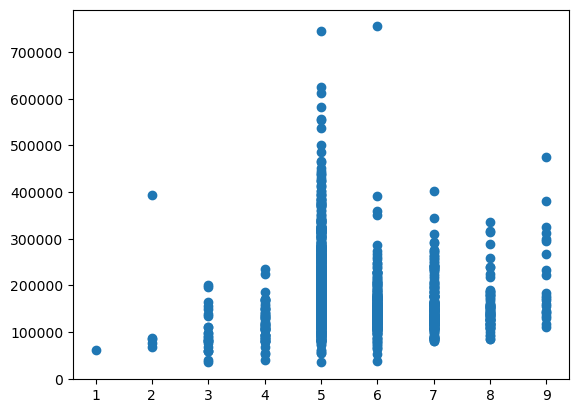

In [16]:
plt.scatter(x='OverallCond', y='SalePrice', data=train_df)

In [17]:
train_df.query('OverallCond == 2')
#379

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
88,89,50,C (all),105.00,8470,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,IDOTRR,Feedr,Feedr,1Fam,1.5Fin,3,2,1915,1982,Hip,CompShg,Plywood,Plywood,NaN,0.00,Fa,Fa,CBlock,TA,Fa,No,Unf,0,Unf,0,1013,1013,GasA,TA,N,SBrkr,1013,0,513,1526,0,0,1,0,2,1,Fa,6,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,156,0,0,0,NaN,MnPrv,NaN,0,10,2009,ConLD,Abnorml,85000
250,251,30,RL,55.00,5350,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,BrkSide,Norm,Norm,1Fam,1Story,3,2,1940,1966,Gable,CompShg,Wd Sdng,Plywood,NaN,0.00,TA,Po,CBlock,TA,TA,No,Unf,0,Unf,0,728,728,GasA,Ex,Y,SBrkr,1306,0,0,1306,0,0,1,0,3,1,Fa,6,Mod,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,263,0,0,0,0,0,NaN,GdWo,Shed,450,5,2010,WD,Normal,76500
378,379,20,RL,88.00,11394,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,StoneBr,Norm,Norm,1Fam,1Story,9,2,2010,2010,Hip,CompShg,VinylSd,VinylSd,Stone,350.00,Gd,TA,PConc,Ex,TA,Av,GLQ,1445,Unf,0,411,1856,GasA,Ex,Y,SBrkr,1856,0,0,1856,1,0,1,1,1,1,Ex,8,Typ,1,Ex,Attchd,2010.00,Fin,3,834,TA,TA,Y,113,0,0,0,0,0,NaN,NaN,NaN,0,6,2010,New,Partial,394432
398,399,30,RM,60.00,8967,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,5,2,1920,1950,Gable,CompShg,MetalSd,MetalSd,NaN,0.00,TA,Fa,BrkTil,Fa,Po,No,Unf,0,Unf,0,961,961,GasA,Gd,Y,Mix,1077,0,0,1077,0,0,1,0,2,1,TA,6,Maj2,0,NaN,Detchd,1920.00,Unf,1,338,Po,Po,N,0,0,0,0,0,0,NaN,NaN,NaN,0,11,2007,WD,Abnorml,67000
676,677,70,RM,60.00,9600,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,2Story,4,2,1900,1950,Gable,CompShg,AsbShng,Stucco,NaN,0.00,TA,TA,BrkTil,TA,Fa,No,Unf,0,Unf,0,1095,1095,GasW,Fa,N,SBrkr,1095,679,0,1774,1,0,2,0,4,2,TA,8,Min2,0,NaN,2Types,1920.00,Unf,3,779,Fa,Fa,N,0,0,90,0,0,0,NaN,NaN,NaN,0,5,2006,WD,Normal,87000


In [18]:
train_df.query('OverallCond == 5 & SalePrice > 700000')
#1183

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1182,1183,60,RL,160.00,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,NaN,0.00,Gd,TA,PConc,Ex,TA,Av,GLQ,2096,Unf,0,300,2396,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1,0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.00,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000


In [19]:
train_df.query('OverallCond == 6 & SalePrice > 700000')
#692

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
691,692,60,RL,104.00,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.00,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2444,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.00,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000


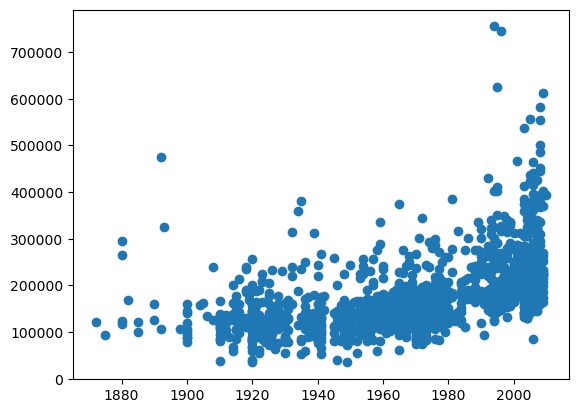

In [20]:
plt.scatter(x='YearBuilt', y='SalePrice', data=train_df)

In [21]:
train_df.query('YearBuilt < 1900 & SalePrice > 200000')
#186

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
185,186,75,RM,90.00,22950,Pave,NaN,IR2,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,2.5Fin,10,9,1892,1993,Gable,WdShngl,Wd Sdng,Wd Sdng,NaN,0.00,Gd,Gd,BrkTil,TA,TA,Mn,Unf,0,Unf,0,1107,1107,GasA,Ex,Y,SBrkr,1518,1518,572,3608,0,0,2,1,4,1,Ex,12,Typ,2,TA,Detchd,1993.00,Unf,3,840,Ex,TA,Y,0,260,0,0,410,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000
304,305,75,RM,87.00,18386,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,2.5Fin,7,9,1880,2002,Gable,CompShg,CemntBd,CmentBd,NaN,0.00,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,1470,1470,GasA,Ex,Y,SBrkr,1675,1818,0,3493,0,0,3,0,3,1,Gd,10,Typ,1,Ex,Attchd,2003.00,Unf,3,870,TA,TA,Y,302,0,0,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal,295000
583,584,75,RM,75.00,13500,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,PosA,1Fam,2.5Unf,10,9,1893,2000,Gable,CompShg,Wd Sdng,Wd Sdng,NaN,0.00,Ex,Ex,BrkTil,TA,TA,No,Unf,0,Unf,0,1237,1237,GasA,Gd,Y,SBrkr,1521,1254,0,2775,0,0,3,1,3,1,Gd,9,Typ,1,Gd,Detchd,1988.00,Unf,2,880,Gd,TA,Y,105,502,0,0,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal,325000
747,748,70,RM,65.00,11700,Pave,Pave,IR1,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,2Story,7,7,1880,2003,Mansard,CompShg,Stucco,Stucco,NaN,0.00,Gd,TA,Stone,TA,Fa,No,Unf,0,Unf,0,1240,1240,GasW,TA,N,SBrkr,1320,1320,0,2640,0,0,1,1,4,1,Gd,8,Typ,1,Gd,Detchd,1950.00,Unf,4,864,TA,TA,N,181,0,386,0,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal,265979


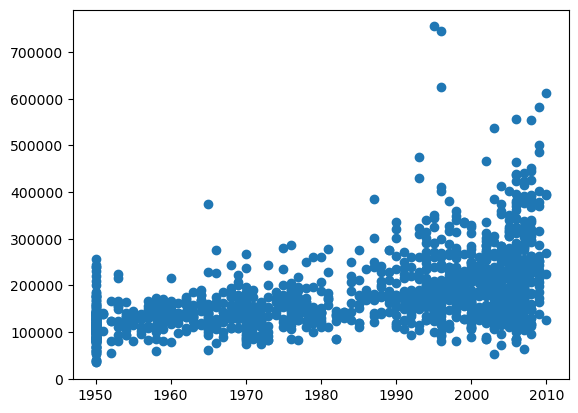

In [22]:
plt.scatter(x='YearRemodAdd', y='SalePrice', data=train_df)

In [23]:
train_df.query('YearRemodAdd < 1970 & SalePrice > 300000')
#314

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
313,314,20,RL,150.00,215245,Pave,NaN,IR3,Low,AllPub,Inside,Sev,Timber,Norm,Norm,1Fam,1Story,7,5,1965,1965,Hip,CompShg,BrkFace,BrkFace,NaN,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,1236,Rec,820,80,2136,GasW,TA,Y,SBrkr,2036,0,0,2036,2,0,2,0,3,1,TA,8,Typ,2,Gd,Attchd,1965.00,RFn,2,513,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal,375000


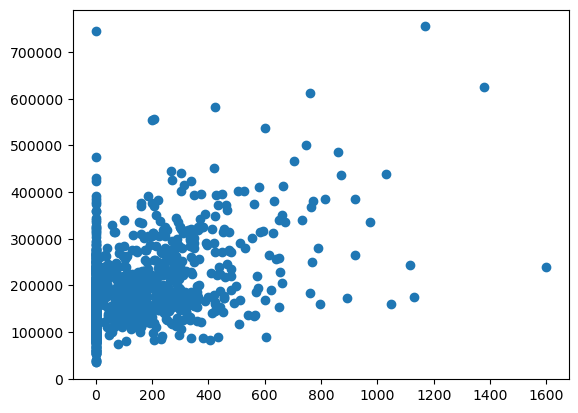

In [24]:
plt.scatter(x='MasVnrArea', y='SalePrice', data=train_df)

In [25]:
train_df.query('MasVnrArea > 1500')
#298

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
297,298,60,FV,66.00,7399,Pave,Pave,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,5,1997,1998,Hip,CompShg,VinylSd,VinylSd,BrkFace,1600.00,Gd,TA,PConc,Gd,TA,No,BLQ,649,Unf,0,326,975,GasA,Ex,Y,SBrkr,975,975,0,1950,0,0,2,1,3,1,Gd,7,Typ,1,TA,Detchd,1997.00,RFn,2,576,TA,TA,Y,0,10,0,0,198,0,NaN,NaN,NaN,0,6,2007,WD,Normal,239000


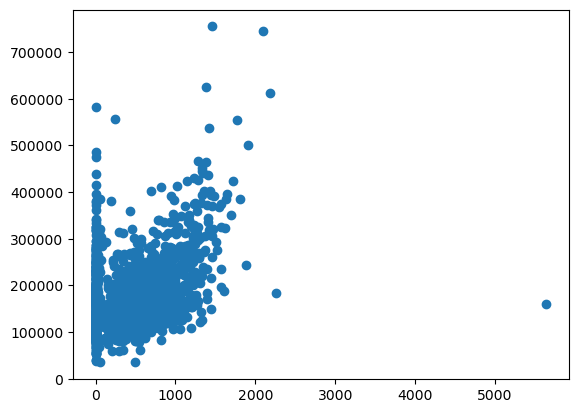

In [26]:
plt.scatter(x='BsmtFinSF1', y='SalePrice', data=train_df)

In [27]:
train_df.query('BsmtFinSF1 > 5000')
#1299

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.00,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.00,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.00,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


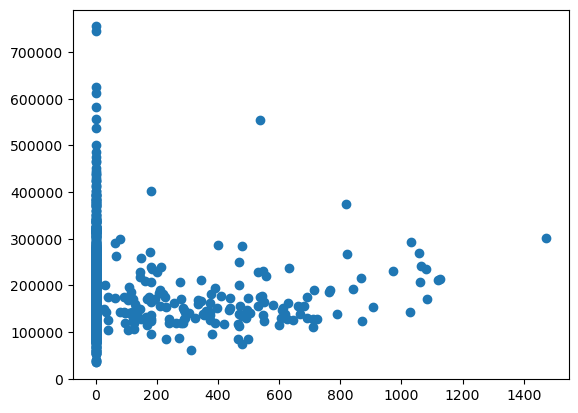

In [28]:
plt.scatter(x='BsmtFinSF2', y='SalePrice', data=train_df)

In [29]:
train_df.query('BsmtFinSF2 > 400 & SalePrice > 500000')
#441

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
440,441,20,RL,105.00,15431,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2008,2008,Hip,CompShg,VinylSd,VinylSd,Stone,200.00,Ex,TA,PConc,Ex,TA,Gd,GLQ,1767,ALQ,539,788,3094,GasA,Ex,Y,SBrkr,2402,0,0,2402,1,0,2,0,2,1,Ex,10,Typ,2,Gd,Attchd,2008.00,Fin,3,672,TA,TA,Y,0,72,0,0,170,0,NaN,NaN,NaN,0,4,2009,WD,Normal,555000


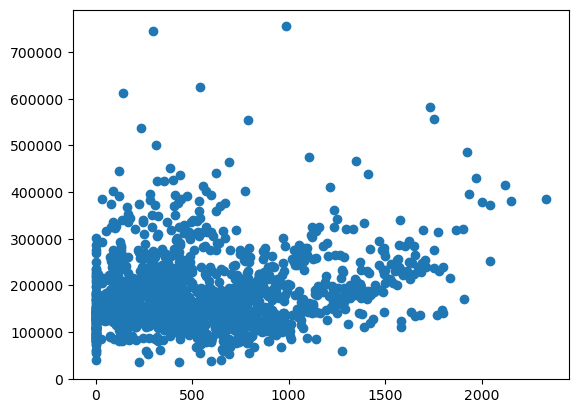

In [30]:
plt.scatter(x='BsmtUnfSF', y='SalePrice', data=train_df)

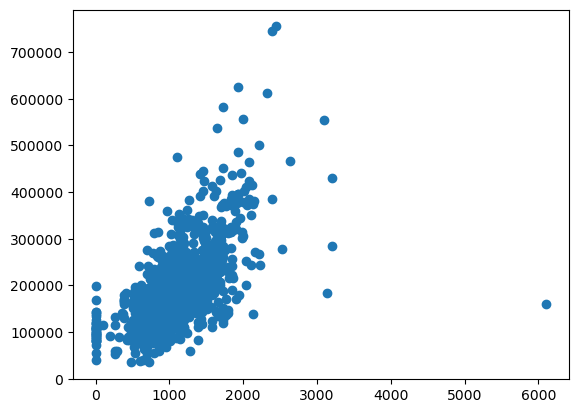

In [31]:
plt.scatter(x='TotalBsmtSF', y='SalePrice', data=train_df)

In [32]:
train_df.query('TotalBsmtSF > 5000')
#1299

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.00,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.00,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.00,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


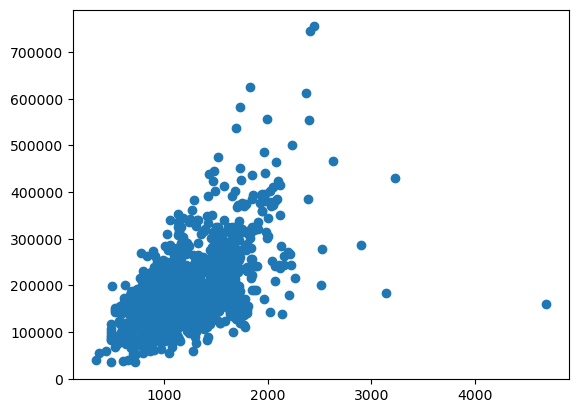

In [33]:
plt.scatter(x='1stFlrSF', y='SalePrice', data=train_df)

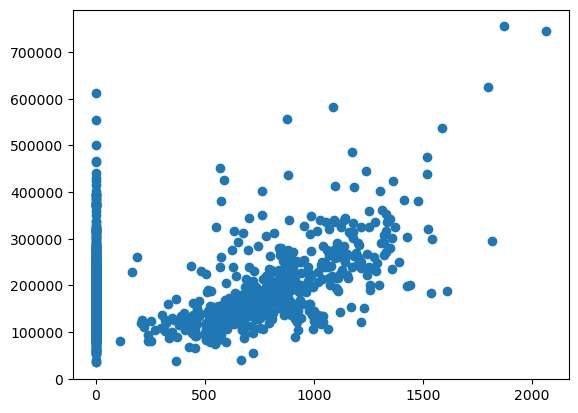

In [34]:
plt.scatter(x='2ndFlrSF', y='SalePrice', data=train_df)

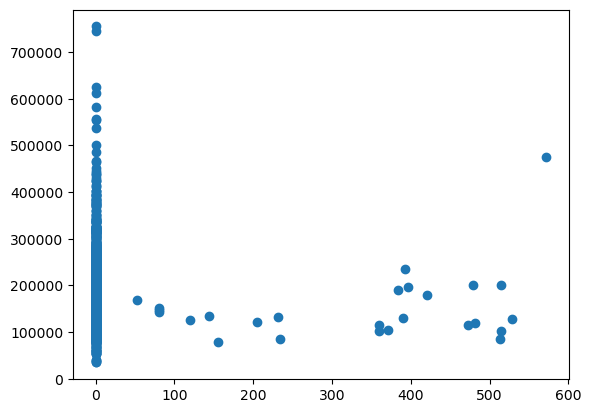

In [35]:
plt.scatter(x='LowQualFinSF', y='SalePrice', data=train_df)

In [36]:
train_df.query('LowQualFinSF > 550')
#186

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
185,186,75,RM,90.00,22950,Pave,NaN,IR2,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,2.5Fin,10,9,1892,1993,Gable,WdShngl,Wd Sdng,Wd Sdng,NaN,0.00,Gd,Gd,BrkTil,TA,TA,Mn,Unf,0,Unf,0,1107,1107,GasA,Ex,Y,SBrkr,1518,1518,572,3608,0,0,2,1,4,1,Ex,12,Typ,2,TA,Detchd,1993.00,Unf,3,840,Ex,TA,Y,0,260,0,0,410,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000


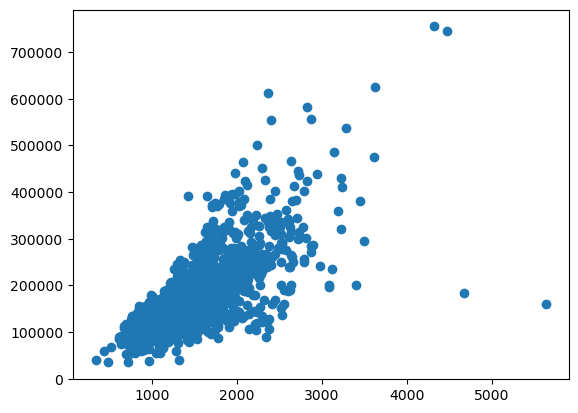

In [37]:
plt.scatter(x='GrLivArea', y='SalePrice', data=train_df)

In [38]:
train_df.query('GrLivArea > 4000')
#524, 692, 1183, 1299

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,130.00,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.00,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.00,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
691,692,60,RL,104.00,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.00,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2444,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.00,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000
1182,1183,60,RL,160.00,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,NaN,0.00,Gd,TA,PConc,Ex,TA,Av,GLQ,2096,Unf,0,300,2396,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1,0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.00,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000
1298,1299,60,RL,313.00,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.00,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.00,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


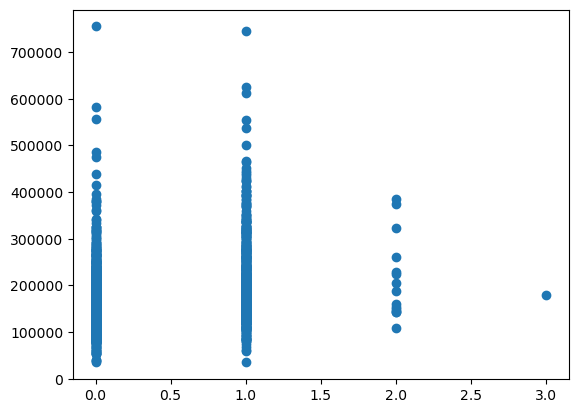

In [39]:
plt.scatter(x='BsmtFullBath', y='SalePrice', data=train_df)

In [40]:
train_df.query('BsmtFullBath > 2.6')
#739

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
738,739,90,RL,60.00,10800,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Duplex,1Story,5,5,1987,1988,Gable,CompShg,Plywood,Plywood,NaN,0.00,TA,TA,CBlock,Gd,Gd,Gd,GLQ,1200,Unf,0,0,1200,GasA,TA,Y,SBrkr,1200,0,0,1200,3,0,3,0,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,120,0,0,0,0,0,NaN,NaN,NaN,0,3,2009,WD,Alloca,179000


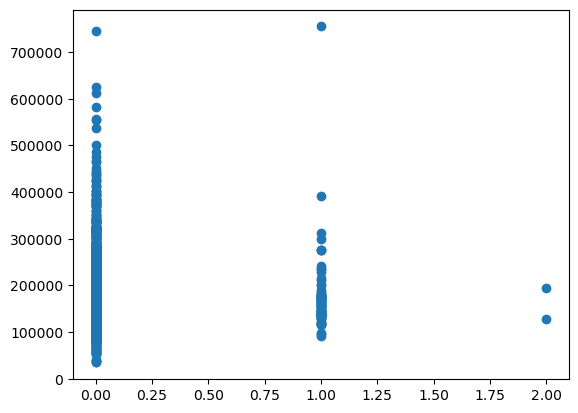

In [41]:
plt.scatter(x='BsmtHalfBath', y='SalePrice', data=train_df)

In [42]:
train_df.query('BsmtHalfBath > 1.5')
#598, 955

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
597,598,120,RL,53.00,3922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Blmngtn,Norm,Norm,TwnhsE,1Story,7,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,BrkFace,72.00,Gd,TA,PConc,Ex,TA,Av,Unf,0,Unf,0,1258,1258,GasA,Ex,Y,SBrkr,1402,0,0,1402,0,2,0,2,2,1,Gd,7,Typ,1,Gd,Attchd,2006.00,Fin,3,648,TA,TA,Y,120,16,0,0,0,0,NaN,NaN,NaN,0,2,2007,New,Partial,194201
954,955,90,RL,35.00,9400,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Edwards,Norm,Norm,Duplex,SFoyer,6,5,1975,1975,Flat,Tar&Grv,WdShing,Plywood,BrkFace,250.00,TA,TA,CBlock,Gd,Gd,Gd,GLQ,945,Unf,0,0,945,GasA,TA,Y,SBrkr,980,0,0,980,0,2,2,0,4,0,TA,4,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,10,2006,WD,AdjLand,127500


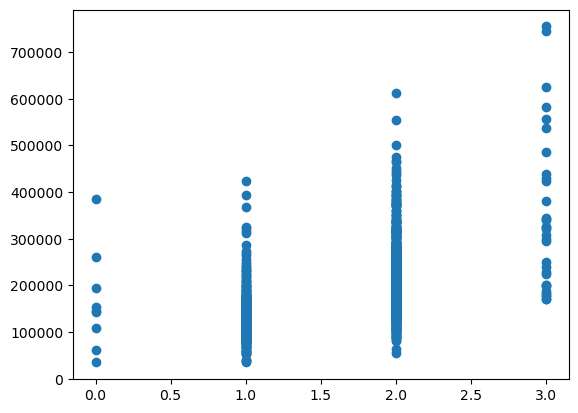

In [43]:
plt.scatter(x='FullBath', y='SalePrice', data=train_df)

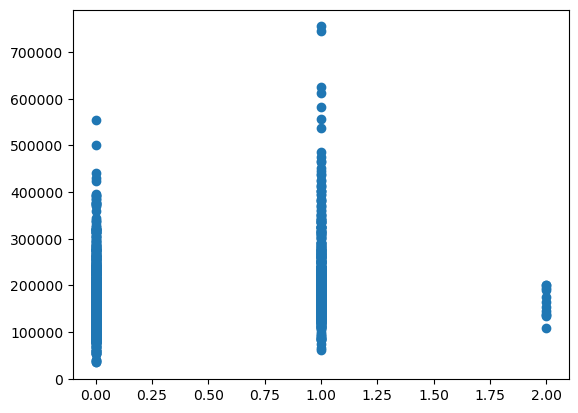

In [44]:
plt.scatter(x='HalfBath', y='SalePrice', data=train_df)

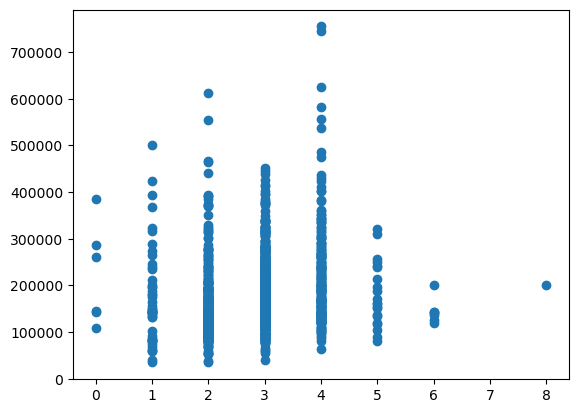

In [45]:
plt.scatter(x='BedroomAbvGr', y='SalePrice', data=train_df)

In [46]:
train_df.query('BedroomAbvGr > 7')
#636

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
635,636,190,RH,60.00,10896,Pave,Pave,Reg,Bnk,AllPub,Inside,Gtl,SWISU,Feedr,Norm,2fmCon,2.5Fin,6,7,1914,1995,Hip,CompShg,VinylSd,VinylSd,NaN,0.00,Fa,TA,CBlock,TA,Fa,No,LwQ,256,Unf,0,1184,1440,GasA,Ex,Y,FuseA,1440,1440,515,3395,0,0,2,0,8,2,Fa,14,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,110,0,0,0,0,NaN,NaN,NaN,0,3,2007,WD,Abnorml,200000


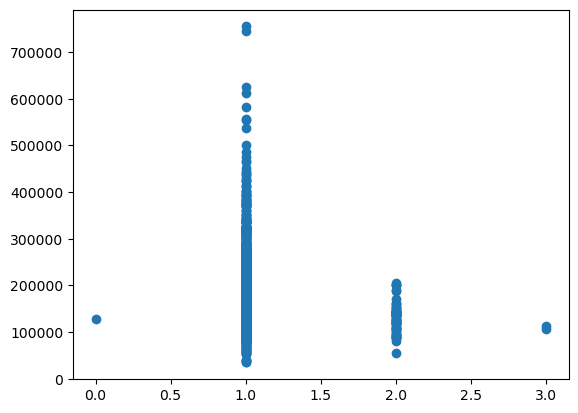

In [47]:
plt.scatter(x='KitchenAbvGr', y='SalePrice', data=train_df)

In [48]:
train_df.query('KitchenAbvGr > 2.6')
#49, 810

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
48,49,190,RM,33.00,4456,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,4,5,1920,2008,Gable,CompShg,MetalSd,MetalSd,NaN,0.00,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,736,736,GasA,Gd,Y,SBrkr,736,716,0,1452,0,0,2,0,2,3,TA,8,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,102,0,0,0,NaN,NaN,NaN,0,6,2009,New,Partial,113000
809,810,75,RM,90.00,8100,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,2.5Unf,5,5,1898,1965,Hip,CompShg,AsbShng,AsbShng,NaN,0.00,TA,TA,PConc,TA,TA,No,Unf,0,Unf,0,849,849,GasA,TA,N,FuseA,1075,1063,0,2138,0,0,2,0,2,3,TA,11,Typ,0,NaN,Detchd,1910.00,Unf,2,360,Fa,Po,N,40,156,0,0,0,0,NaN,MnPrv,NaN,0,11,2009,WD,Normal,106000


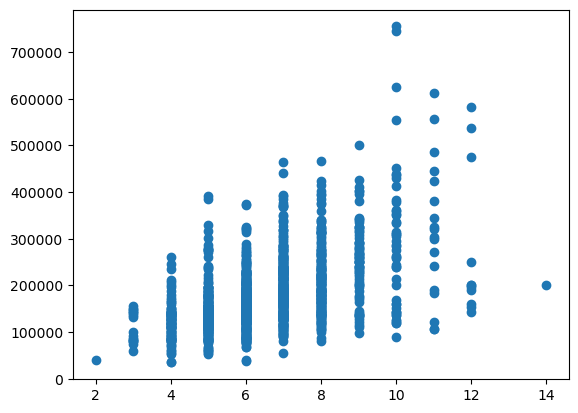

In [49]:
plt.scatter(x='TotRmsAbvGrd', y='SalePrice', data=train_df)

In [50]:
train_df.query('TotRmsAbvGrd > 13')
#636

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
635,636,190,RH,60.00,10896,Pave,Pave,Reg,Bnk,AllPub,Inside,Gtl,SWISU,Feedr,Norm,2fmCon,2.5Fin,6,7,1914,1995,Hip,CompShg,VinylSd,VinylSd,NaN,0.00,Fa,TA,CBlock,TA,Fa,No,LwQ,256,Unf,0,1184,1440,GasA,Ex,Y,FuseA,1440,1440,515,3395,0,0,2,0,8,2,Fa,14,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,110,0,0,0,0,NaN,NaN,NaN,0,3,2007,WD,Abnorml,200000


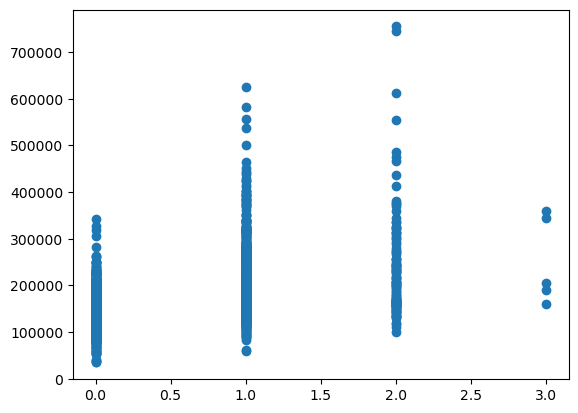

In [51]:
plt.scatter(x='Fireplaces', y='SalePrice', data=train_df)

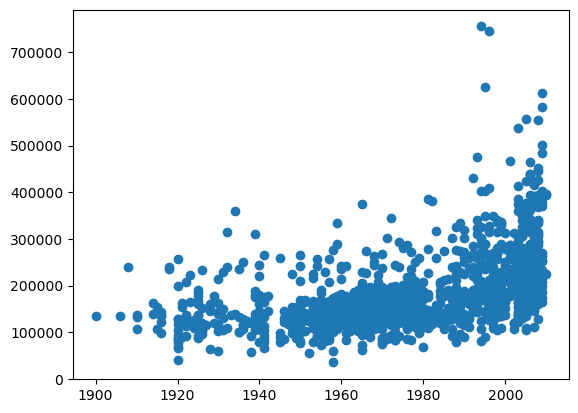

In [52]:
plt.scatter(x='GarageYrBlt', y='SalePrice', data=train_df)

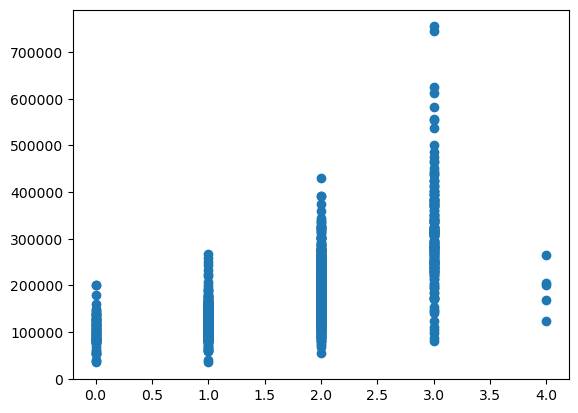

In [53]:
plt.scatter(x='GarageCars', y='SalePrice', data=train_df)

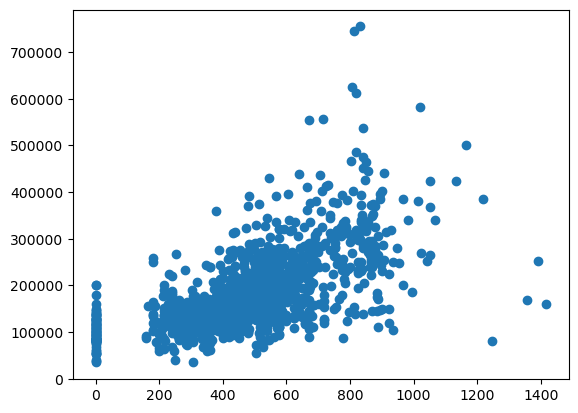

In [54]:
plt.scatter(x='GarageArea', y='SalePrice', data=train_df)

In [55]:
train_df.query('GarageArea > 1200')
#1062, 1191

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
581,582,20,RL,98.00,12704,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,8,5,2008,2009,Hip,CompShg,VinylSd,VinylSd,BrkFace,306.00,Ex,TA,PConc,Ex,TA,No,Unf,0,Unf,0,2042,2042,GasA,Ex,Y,SBrkr,2042,0,0,2042,0,0,2,1,3,1,Ex,8,Typ,1,Gd,Attchd,2009.00,RFn,3,1390,TA,TA,Y,0,90,0,0,0,0,NaN,NaN,NaN,0,8,2009,New,Partial,253293
825,826,20,RL,114.00,14803,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,PosN,PosN,1Fam,1Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,BrkFace,816.00,Ex,TA,PConc,Ex,TA,Av,GLQ,1636,Unf,0,442,2078,GasA,Ex,Y,SBrkr,2084,0,0,2084,1,0,2,0,2,1,Ex,7,Typ,1,Gd,Attchd,2007.00,Fin,3,1220,TA,TA,Y,188,45,0,0,0,0,NaN,NaN,NaN,0,6,2008,New,Partial,385000
1061,1062,30,C (all),120.00,18000,Grvl,NaN,Reg,Low,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,3,4,1935,1950,Gable,CompShg,MetalSd,MetalSd,NaN,0.00,Fa,TA,CBlock,TA,TA,No,Unf,0,Unf,0,894,894,GasA,TA,Y,SBrkr,894,0,0,894,0,0,1,0,2,1,TA,6,Typ,0,NaN,Detchd,1994.00,RFn,3,1248,TA,TA,Y,0,20,0,0,0,0,NaN,NaN,Shed,560,8,2008,ConLD,Normal,81000
1190,1191,190,RL,NaN,32463,Pave,NaN,Reg,Low,AllPub,Inside,Mod,Mitchel,Norm,Norm,2fmCon,1Story,4,4,1961,1975,Gable,CompShg,MetalSd,MetalSd,Stone,149.00,TA,Gd,CBlock,TA,TA,Av,BLQ,1159,Unf,0,90,1249,GasA,Ex,Y,SBrkr,1622,0,0,1622,1,0,1,0,3,1,TA,7,Typ,1,TA,2Types,1975.00,Fin,4,1356,TA,TA,Y,439,0,0,0,0,0,NaN,NaN,NaN,0,3,2007,WD,Normal,168000
1298,1299,60,RL,313.00,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.00,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.00,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


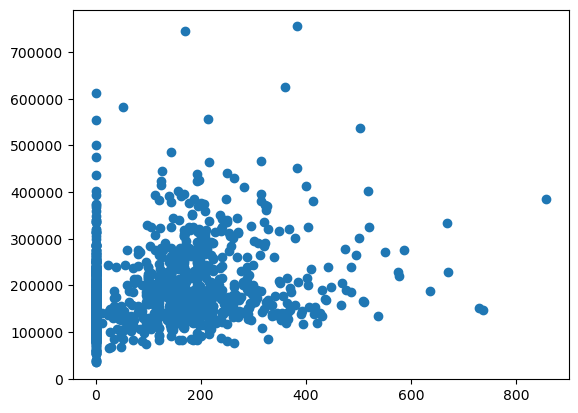

In [56]:
plt.scatter(x='WoodDeckSF', y='SalePrice', data=train_df)

In [57]:
train_df.query('WoodDeckSF > 750')
#54

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
53,54,20,RL,68.00,50271,Pave,NaN,IR1,Low,AllPub,Inside,Gtl,Veenker,Norm,Norm,1Fam,1Story,9,5,1981,1987,Gable,WdShngl,WdShing,Wd Shng,NaN,0.00,Gd,TA,CBlock,Ex,TA,Gd,GLQ,1810,Unf,0,32,1842,GasA,Gd,Y,SBrkr,1842,0,0,1842,2,0,0,1,0,1,Gd,5,Typ,1,Gd,Attchd,1981.00,Fin,3,894,TA,TA,Y,857,72,0,0,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal,385000


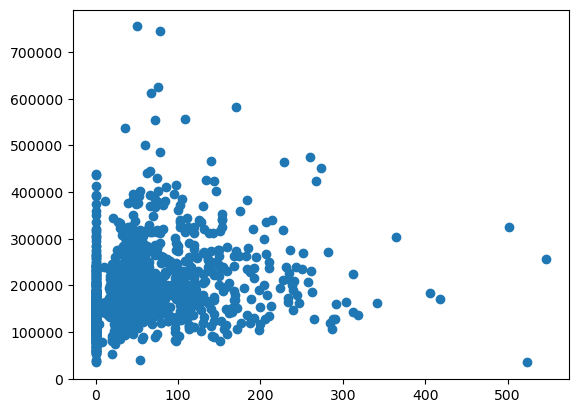

In [58]:
plt.scatter(x='OpenPorchSF', y='SalePrice', data=train_df)

In [59]:
train_df.query('OpenPorchSF > 500')
#496

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
495,496,30,C (all),60.00,7879,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,4,5,1920,1950,Gable,CompShg,Wd Sdng,Wd Sdng,NaN,0.00,TA,TA,CBlock,TA,TA,No,Rec,495,Unf,0,225,720,GasA,TA,N,FuseA,720,0,0,720,0,0,1,0,2,1,TA,4,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,523,115,0,0,0,NaN,GdWo,NaN,0,11,2009,WD,Abnorml,34900
583,584,75,RM,75.00,13500,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,PosA,1Fam,2.5Unf,10,9,1893,2000,Gable,CompShg,Wd Sdng,Wd Sdng,NaN,0.00,Ex,Ex,BrkTil,TA,TA,No,Unf,0,Unf,0,1237,1237,GasA,Gd,Y,SBrkr,1521,1254,0,2775,0,0,3,1,3,1,Gd,9,Typ,1,Gd,Detchd,1988.00,Unf,2,880,Gd,TA,Y,105,502,0,0,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal,325000
1328,1329,50,RM,60.00,10440,Pave,Grvl,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,1.5Fin,6,7,1920,1950,Gable,CompShg,BrkFace,Wd Sdng,NaN,0.00,Gd,Gd,BrkTil,Gd,TA,No,LwQ,493,Unf,0,1017,1510,GasW,Ex,Y,SBrkr,1584,1208,0,2792,0,0,2,0,5,1,TA,8,Mod,2,TA,Detchd,1920.00,Unf,2,520,Fa,TA,Y,0,547,0,0,480,0,NaN,MnPrv,Shed,1150,6,2008,WD,Normal,256000


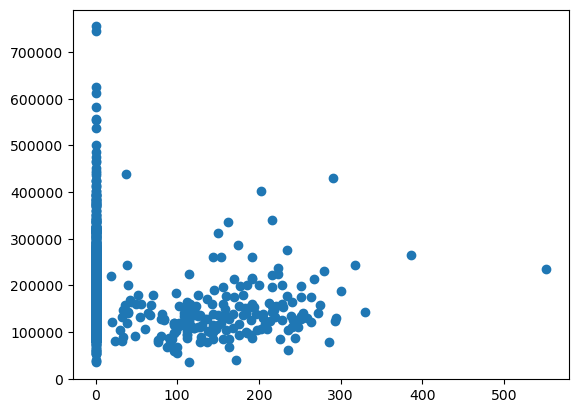

In [60]:
plt.scatter(x='EnclosedPorch', y='SalePrice', data=train_df)

In [61]:
train_df.query('EnclosedPorch > 500')
#198

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
197,198,75,RL,174.00,25419,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Artery,Norm,1Fam,2Story,8,4,1918,1990,Gable,CompShg,Stucco,Stucco,NaN,0.00,Gd,Gd,PConc,TA,TA,No,GLQ,1036,LwQ,184,140,1360,GasA,Gd,Y,SBrkr,1360,1360,392,3112,1,1,2,0,4,1,Gd,8,Typ,1,Ex,Detchd,1918.00,Unf,2,795,TA,TA,Y,0,16,552,0,0,512,Ex,GdPrv,NaN,0,3,2006,WD,Abnorml,235000


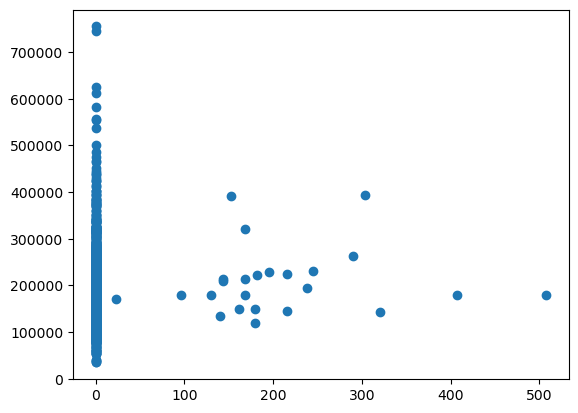

In [62]:
plt.scatter(x='3SsnPorch', y='SalePrice', data=train_df)

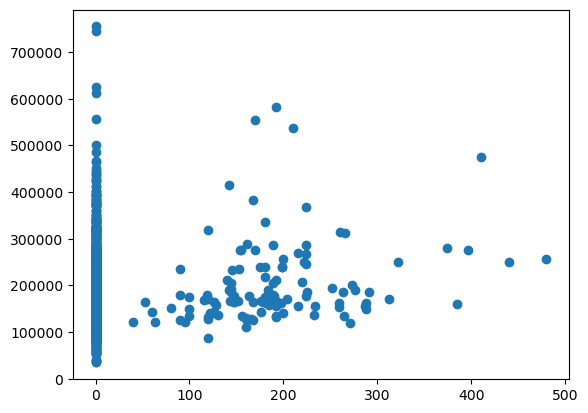

In [63]:
plt.scatter(x='ScreenPorch', y='SalePrice', data=train_df)

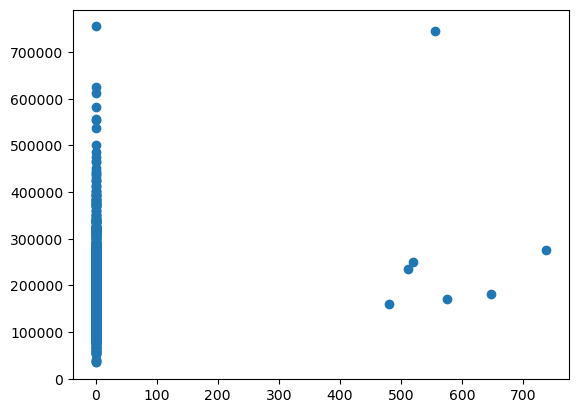

In [64]:
plt.scatter(x='PoolArea', y='SalePrice', data=train_df)

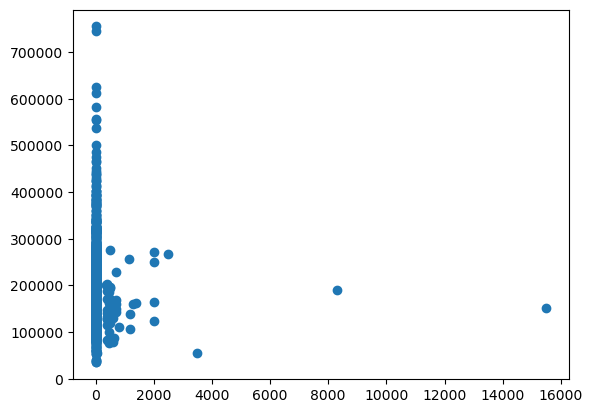

In [65]:
plt.scatter(x='MiscVal', y='SalePrice', data=train_df)

In [66]:
# outliers
values = [598, 955, 935, 1299, 250, 314, 336, 707, 379, 1183, 692, 186, 441, 186, 524, 739, 598, 955, 636, 1062, 1191, 496, 198, 1338]

In [67]:
# droping outliers
train_df = train_df[train_df.Id.isin(values) == False]

In [68]:
# EDA - Null Values

pd.DataFrame(train_df.isnull().sum().sort_values(ascending = False)).head(20)

,0
PoolQC,1435
MiscFeature,1388
Alley,1350
Fence,1162
MasVnrType,861
FireplaceQu,684
LotFrontage,255
GarageYrBlt,76
GarageCond,76
GarageType,76


In [69]:
train_df['MiscFeature'].unique()

array([nan, 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

In [70]:
train_df['Alley'].unique()

array([nan, 'Grvl', 'Pave'], dtype=object)

In [71]:
train_df['Alley'].fillna('No', inplace=True)
test_df['Alley'].fillna('No', inplace=True)

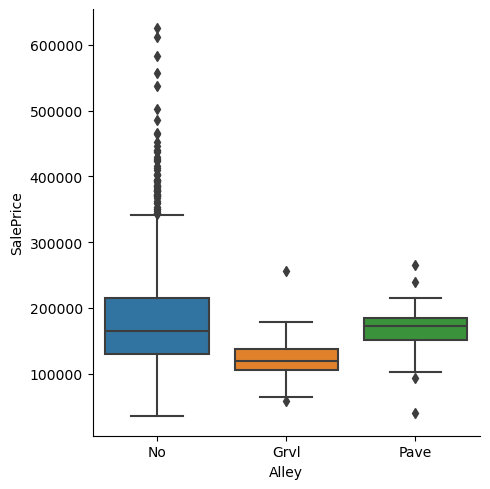

In [72]:
sns.catplot(data=train_df, x='Alley', y='SalePrice', kind='box')

In [73]:
train_df['Fence'].unique()

array([nan, 'MnPrv', 'GdWo', 'GdPrv', 'MnWw'], dtype=object)

In [74]:
train_df['Fence'].fillna('No', inplace=True)
test_df['Fence'].fillna('No', inplace=True)

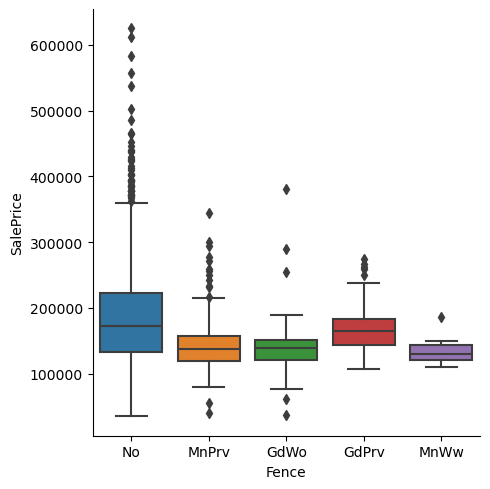

In [75]:
sns.catplot(data=train_df, x='Fence', y='SalePrice', kind='box')

In [76]:
train_df['MasVnrType'].unique()

array(['BrkFace', nan, 'Stone', 'BrkCmn'], dtype=object)

In [77]:
train_df['MasVnrType'].fillna('No', inplace=True)
test_df['MasVnrType'].fillna('No', inplace=True)

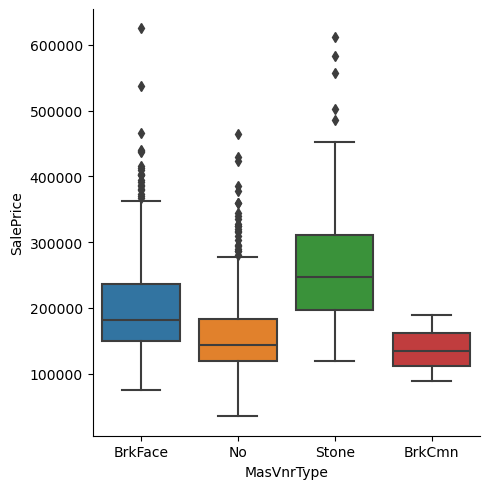

In [78]:
sns.catplot(data=train_df, x='MasVnrType', y='SalePrice', kind='box')

In [79]:
train_df['MasVnrArea'].fillna(0, inplace=True)
test_df['MasVnrArea'].fillna(0, inplace=True)

In [80]:
train_df['FireplaceQu'].unique()

array([nan, 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

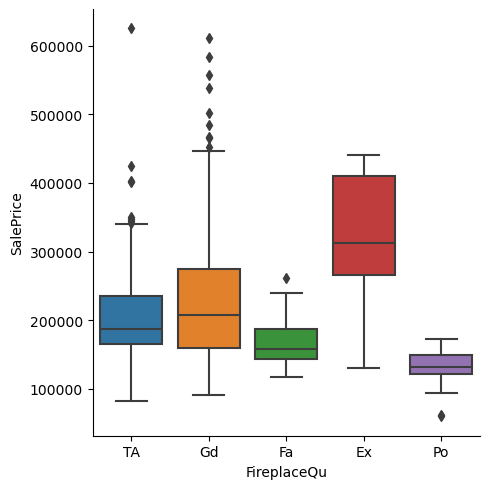

In [81]:
sns.catplot(data=train_df, x='FireplaceQu', y='SalePrice', kind='box')

In [82]:
train_df['FireplaceQu'].fillna('No', inplace=True)
test_df['FireplaceQu'].fillna('No', inplace=True)

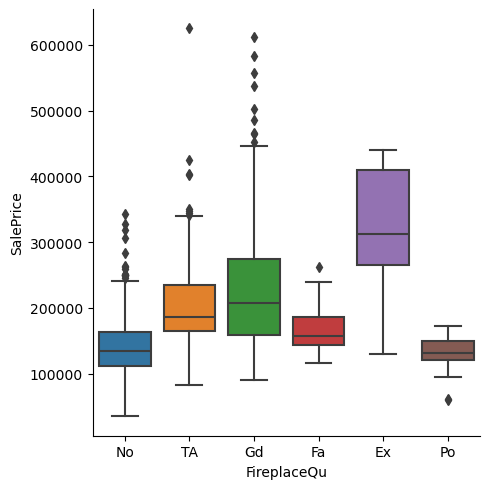

In [83]:
sns.catplot(data=train_df, x='FireplaceQu', y='SalePrice', kind='box')

In [84]:
train_df['LotFrontage'].fillna(0, inplace=True)
test_df['LotFrontage'].fillna(0, inplace=True)

In [85]:
train_df['GarageCond'].unique()

array(['TA', 'Fa', nan, 'Gd', 'Po', 'Ex'], dtype=object)

In [86]:
train_df['GarageCond'].fillna('No', inplace=True)
test_df['GarageCond'].fillna('No', inplace=True)

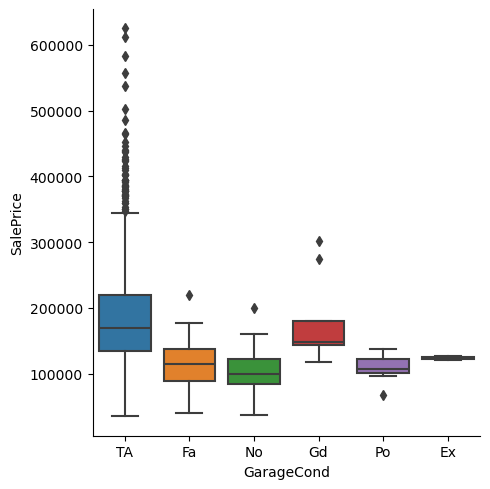

In [87]:
sns.catplot(data=train_df, x='GarageCond', y='SalePrice', kind='box')

In [88]:
train_df['GarageType'].unique()

array(['Attchd', 'Detchd', 'BuiltIn', 'CarPort', nan, 'Basment', '2Types'],
      dtype=object)

In [89]:
train_df['GarageType'].fillna('No', inplace=True)
test_df['GarageType'].fillna('No', inplace=True)

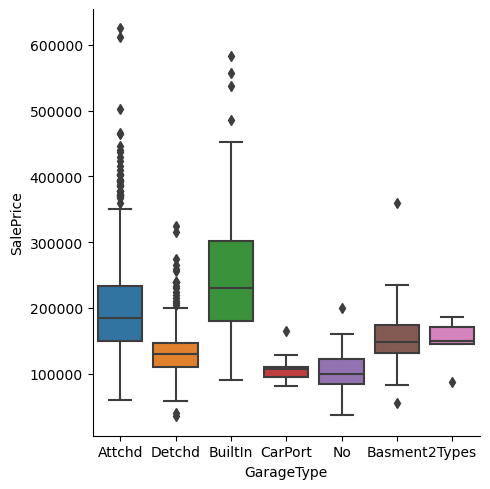

In [90]:
sns.catplot(data=train_df, x='GarageType', y='SalePrice', kind='box')

In [91]:
train_df['GarageFinish'].unique()

array(['RFn', 'Unf', 'Fin', nan], dtype=object)

In [92]:
train_df['GarageFinish'].fillna('No', inplace=True)
test_df['GarageFinish'].fillna('No', inplace=True)

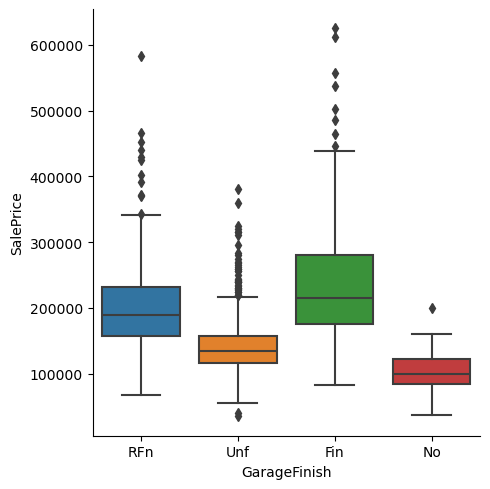

In [93]:
sns.catplot(data=train_df, x='GarageFinish', y='SalePrice', kind='box')

In [94]:
train_df['GarageQual'].unique()

array(['TA', 'Fa', 'Gd', nan, 'Po', 'Ex'], dtype=object)

In [95]:
train_df['GarageQual'].fillna('No', inplace=True)
test_df['GarageQual'].fillna('No', inplace=True)

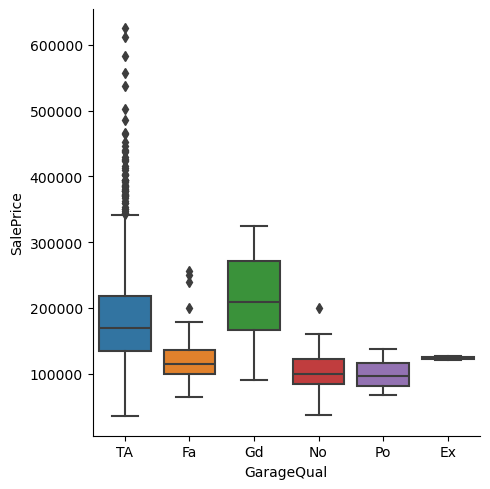

In [96]:
sns.catplot(data=train_df, x='GarageQual', y='SalePrice', kind='box')

In [97]:
train_df['BsmtFinType2'].unique()

array(['Unf', 'BLQ', nan, 'ALQ', 'Rec', 'LwQ', 'GLQ'], dtype=object)

In [98]:
train_df['BsmtFinType2'].fillna('Unf', inplace=True)
test_df['BsmtFinType2'].fillna('Unf', inplace=True)

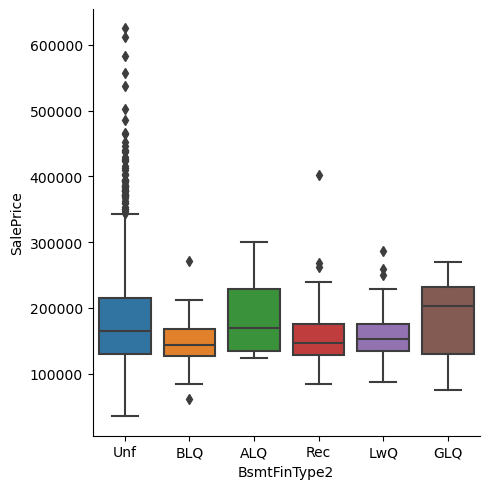

In [99]:
sns.catplot(data=train_df, x='BsmtFinType2', y='SalePrice', kind='box')

In [100]:
train_df['BsmtExposure'].unique()

array(['No', 'Gd', 'Mn', 'Av', nan], dtype=object)

In [101]:
train_df['BsmtExposure'].fillna('No', inplace=True)
test_df['BsmtExposure'].fillna('No', inplace=True)

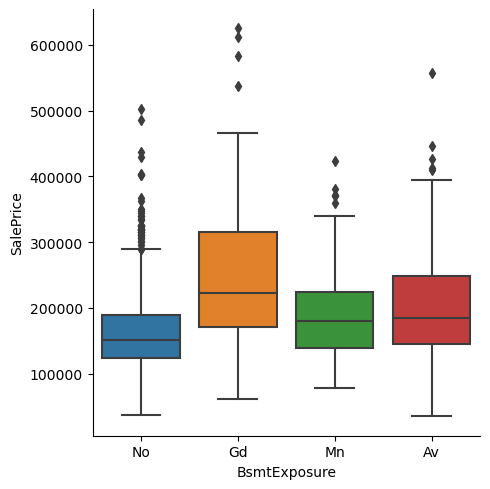

In [102]:
sns.catplot(data=train_df, x='BsmtExposure', y='SalePrice', kind='box')

In [103]:
train_df['BsmtQual'].unique()

array(['Gd', 'TA', 'Ex', nan, 'Fa'], dtype=object)

In [104]:
train_df['BsmtQual'].fillna('No', inplace=True)
test_df['BsmtQual'].fillna('No', inplace=True)

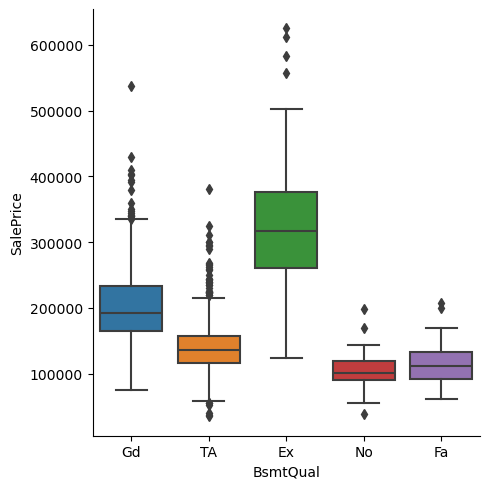

In [105]:
sns.catplot(data=train_df, x='BsmtQual', y='SalePrice', kind='box')

In [106]:
train_df['BsmtCond'].unique()

array(['TA', 'Gd', nan, 'Fa', 'Po'], dtype=object)

In [107]:
train_df['BsmtCond'].fillna('No', inplace=True)
test_df['BsmtCond'].fillna('No', inplace=True)

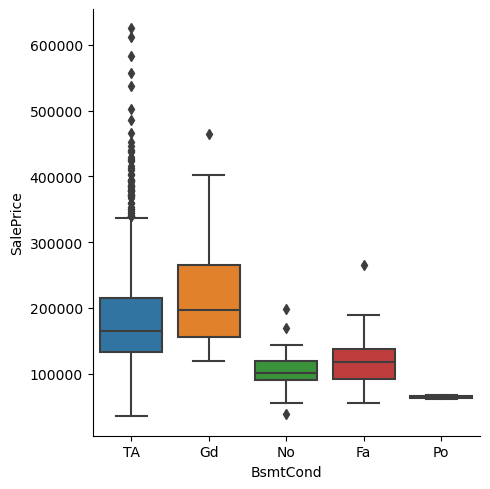

In [108]:
sns.catplot(data=train_df, x='BsmtCond', y='SalePrice', kind='box')

In [109]:
train_df['BsmtFinType1'].unique()

array(['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', nan, 'LwQ'], dtype=object)

In [110]:
train_df['BsmtFinType1'].fillna('Unf', inplace=True)
test_df['BsmtFinType1'].fillna('Unf', inplace=True)

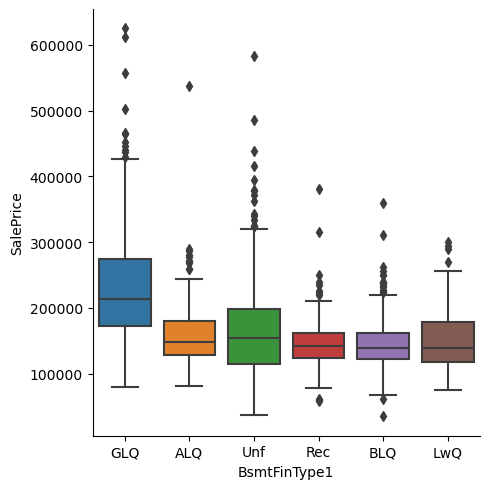

In [111]:
sns.catplot(data=train_df, x='BsmtFinType1', y='SalePrice', kind='box')

In [112]:
train_df['MasVnrArea'].fillna(0, inplace=True)
test_df['MasVnrArea'].fillna(0, inplace=True)

In [113]:
train_df['Electrical'].fillna('SBrkr', inplace=True)
test_df['Electrical'].fillna('SBrkr', inplace=True)

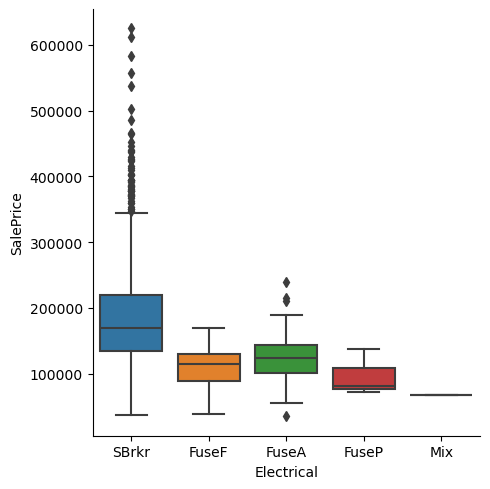

In [114]:
sns.catplot(data=train_df, x='Electrical', y='SalePrice', kind='box')

In [115]:
# droping colums "unrelevant"

train_df = train_df.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'GarageYrBlt', 'GarageCond', 'BsmtFinType2'])
test_df = test_df.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'GarageYrBlt', 'GarageCond', 'BsmtFinType2'])

In [116]:
# feature engineering

train_df['HouseAge'] = train_df['YrSold'] - train_df['YearBuilt']
test_df['HouseAge'] = test_df['YrSold'] - test_df['YearBuilt']

train_df['HouseRemodelAge'] = train_df['YrSold'] - train_df['YearRemodAdd']
test_df['HouseRemodelAge'] = test_df['YrSold'] - test_df['YearRemodAdd']

train_df['TotalSF'] = train_df['1stFlrSF'] + train_df['2ndFlrSF'] + train_df['BsmtFinSF1'] + train_df['BsmtFinSF2']
test_df['TotalSF'] = test_df['1stFlrSF'] + test_df['2ndFlrSF'] + test_df['BsmtFinSF1'] + test_df['BsmtFinSF2']

train_df['TotalArea'] = train_df['GrLivArea'] + train_df['TotalBsmtSF']
test_df['TotalArea'] = test_df['GrLivArea'] + test_df['TotalBsmtSF']

train_df['TotalBaths'] = train_df['BsmtFullBath'] + train_df['FullBath'] + 0.5 * (train_df['BsmtHalfBath'] + train_df['HalfBath'])
test_df['TotalBaths'] = test_df['BsmtFullBath'] + test_df['FullBath'] + 0.5 * (test_df['BsmtHalfBath'] + test_df['HalfBath'])

train_df['TotalPorchSF'] = train_df['OpenPorchSF'] + train_df['3SsnPorch'] + train_df['EnclosedPorch'] + train_df['ScreenPorch'] + train_df['WoodDeckSF']
test_df['TotalPorchSF'] = test_df['OpenPorchSF'] + test_df['3SsnPorch'] + test_df['EnclosedPorch'] + test_df['ScreenPorch'] + test_df['WoodDeckSF']

In [117]:
# dropping obsolet features and ID
train_df = train_df.drop(columns=['YrSold', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GrLivArea', 'TotalBsmtSF','BsmtFullBath', 
                                  'FullBath', 'BsmtHalfBath', 'HalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF'])

test_df = test_df.drop(columns=['YrSold', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GrLivArea', 'TotalBsmtSF','BsmtFullBath', 'FullBath',
                                'BsmtHalfBath', 'HalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF'])

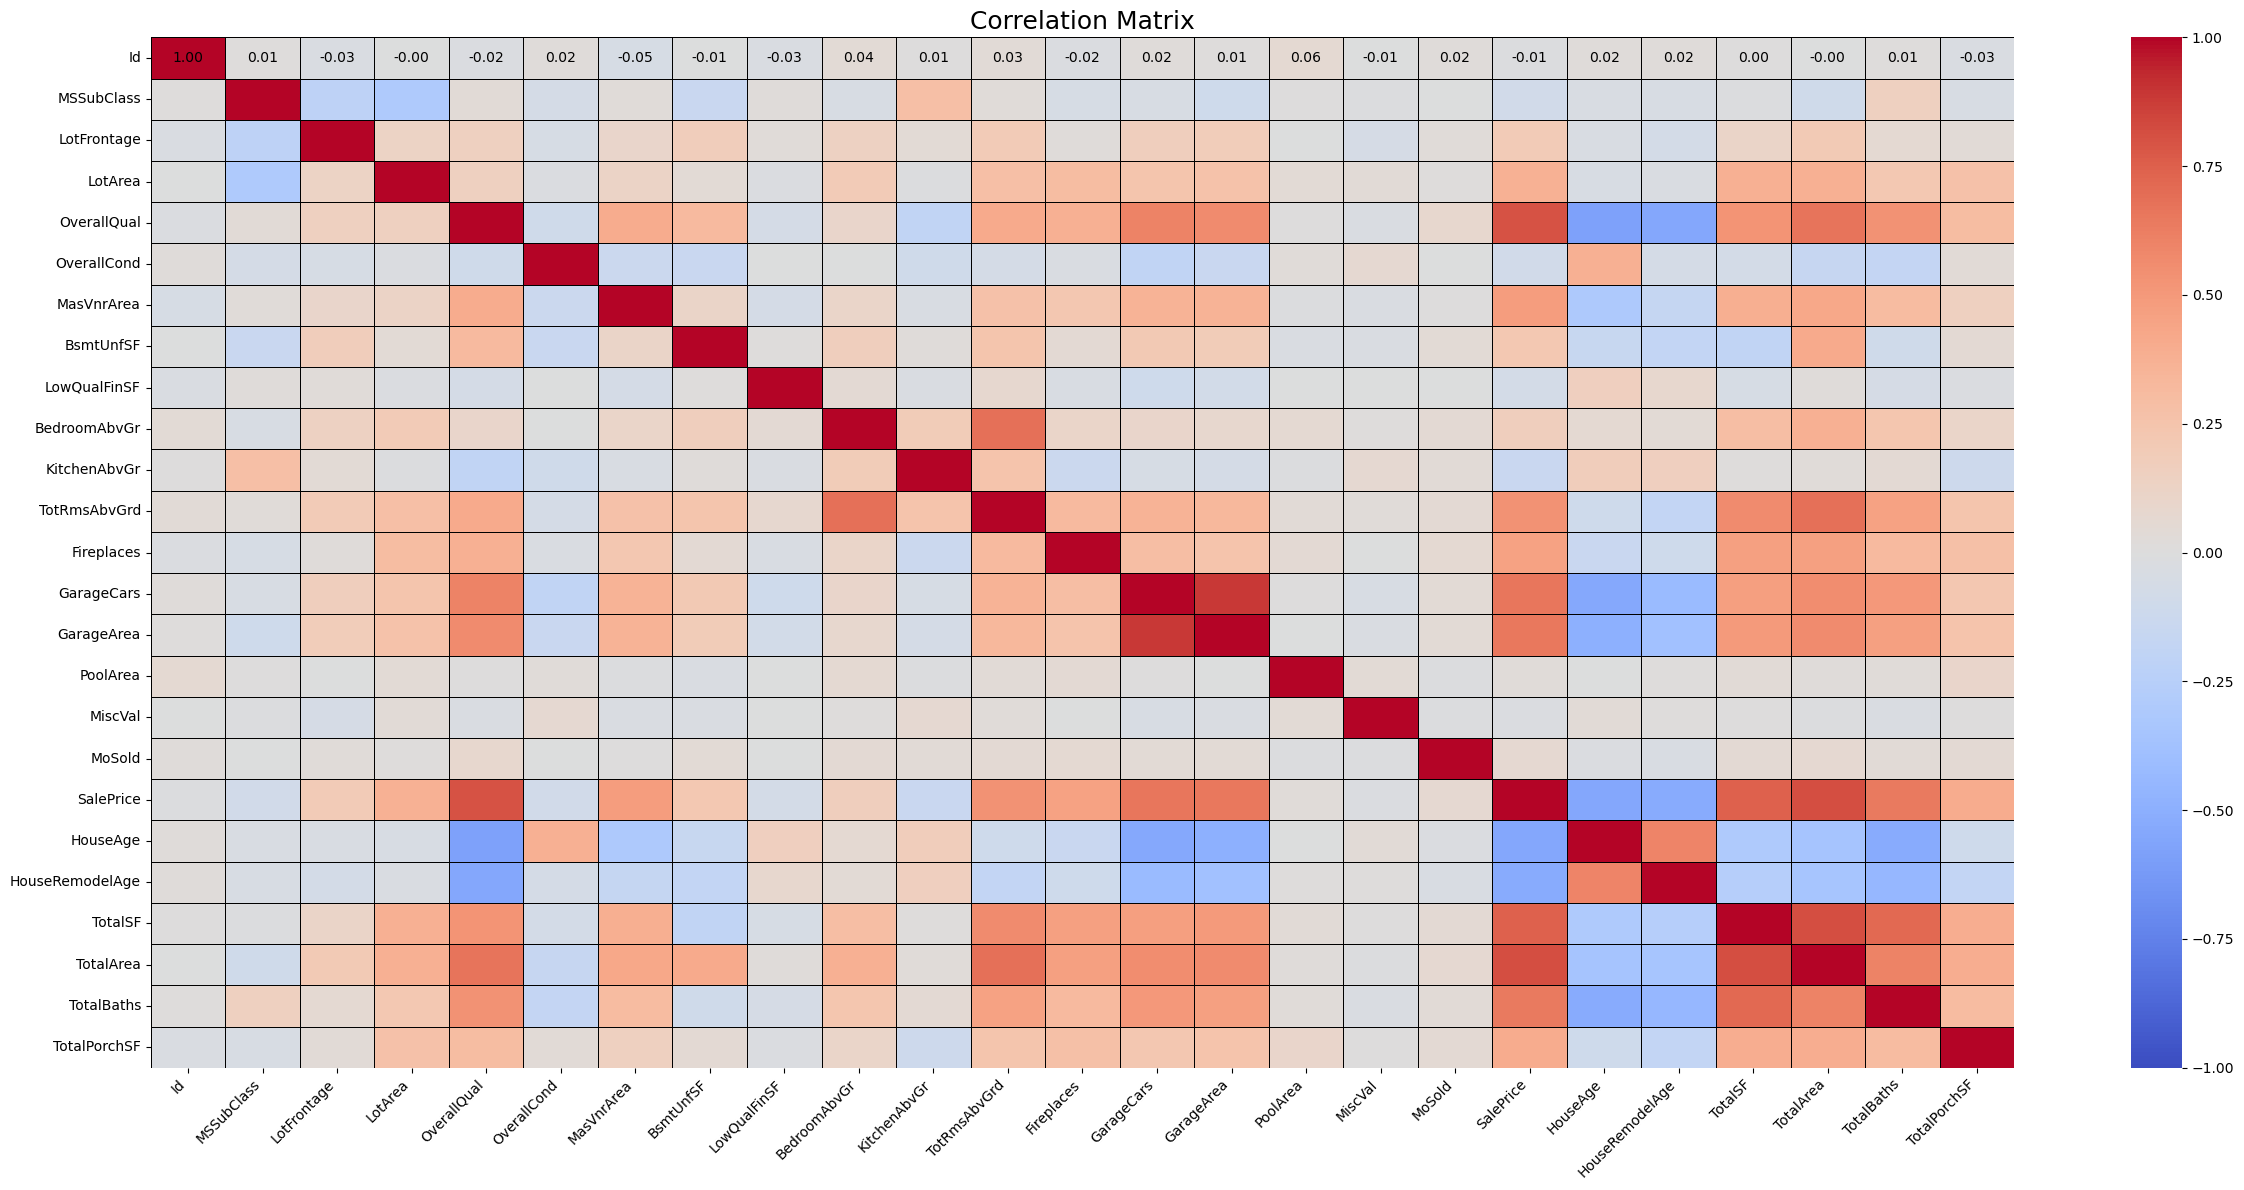

In [118]:
correlation_matrix = train_df.corr(numeric_only=True)

plt.figure(figsize=(25, 12))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    annot_kws={"color": "black"},
    vmin=-1, vmax=1,               
    linewidths=0.5,
    linecolor="black"
)
plt.title("Correlation Matrix", fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [119]:
# drop GarageArea or GarageCars
# since GarageArea has -0.1 less then cars, im gonna drop GarageArea 
train_df = train_df.drop(columns=['GarageArea'])
test_df = test_df.drop(columns=['GarageArea'])

## 3) Preprocessing, modeling and evaluation

In [120]:
modeling_df = train_df.copy()

# Prepare X and y
y = modeling_df['SalePrice']
X = modeling_df.drop(['SalePrice', 'Id'], axis=1)

test_X = test_df.copy().drop('Id', axis=1, errors='ignore')

# Define numeric and categorical columns
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

In [121]:
# Define preprocessing pipelines
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])

In [122]:
# Build model wrappers with TransformedTargetRegressor

def make_model(reg):
    pipe = Pipeline([('preproc', preprocessor), ('model', reg)])
    return TransformedTargetRegressor(regressor=pipe, func=np.log1p, inverse_func=np.expm1)

models = {}

models['Ridge'] = make_model(Ridge(random_state=RANDOM_STATE))

models['RandomForest'] = make_model(RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1))

models['XGBoost'] = make_model(XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE, n_jobs=-1, tree_method='hist'))

models['LightGBM'] = make_model(LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1))

models['CatBoost'] = make_model(CatBoostRegressor(verbose=0, random_state=RANDOM_STATE))

In [127]:
# Cross-validate models
results = []

for name, mdl in models.items():
    scores = cross_val_score(mdl, X, y, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    results.append((name, -scores.mean()))

results_df = pd.DataFrame(results, columns=['model','cv_rmse']).sort_values('cv_rmse')

results_df

,model,cv_rmse
4,CatBoost,20338.95
0,Ridge,20399.95
3,LightGBM,22913.53
2,XGBoost,24219.97
1,RandomForest,24806.98


In [128]:
# --- Helper function to safely extract the base regressor ---
def extract_base_regressor(ttr_model):
    # After .fit(), the internal pipeline is under regressor_
    return ttr_model.regressor.named_steps['model']

# --- Build stacking with top-3 models ---
top3 = results_df['model'].tolist()[:3]
estimators = []

for name in top3:
    base = extract_base_regressor(models[name])
    estimators.append(
        (name, Pipeline([('preproc', preprocessor), ('model', base)]))
    )

stack = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(),
    n_jobs=-1
)

# Wrap stacking inside target transform
stack_ttr = TransformedTargetRegressor(
    regressor=stack,
    func=np.log1p,
    inverse_func=np.expm1
)

# Evaluate stacking
scores = cross_val_score(
    stack_ttr, X, y,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
print("Stacking RMSE:", -scores.mean())

Stacking RMSE: 19292.23780607754


In [129]:
# Fit final model, predict and create submission
final_model = stack_ttr
final_model.fit(X, y)

preds = final_model.predict(test_X)

submission = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': preds})

submission['Id'] = test_df['Id']
submission.to_csv('submission.csv', index=False)
print('Saved submission.csv')

Saved submission.csv
